# Truck deliverly service analysis
## objective
* Builld a model that predict ontime/delay
* Identify feasures that influece the predication


I use the dataset provided by RAM THAIAGU. Thanks!
Dataset downloaded from Kaggle: https://www.kaggle.com/datasets/ramakrishnanthiyagu/delivery-truck-trips-data <br>
Following notebook is used as starting point for this project: https://www.kaggle.com/code/yujiyamamoto/logistics-service-analysis

## Methodology

We first started with some data exploration in the jupyter notebook<br>
After which we cleaned the data in 3 different ways.<br>
For each cleaned dataset we did an inital classification training and evaluation using the classifier of XGBBoost library <br>
We also experimented with a library call 'TPOT' which is an autoML that optimizes machine learning pipelines using genetic programming. No better results were obtained. <br> <br>

Based on the evaluation of the 3 datasets using XGBClassifier we decided on our final dataset to further train and create experiments using Determined AI's platform. <br>

## Data Sample explanation

### Before cleaning

Dataset:

GpsProvider - Vendor who provides GPS<br>
BookingID - Unique Identification for a trip<br>
Market/Regular - Type of trip. Regular - Vendors with whom we will have contract. Market - Vendor with whom we will not have contract<br>
BookingID_Date - Date when booking was created<br>
vehicle_no - Truck Number<br>
Origin_Location - Trip start place<br>
Destination_Location - Trip end place<br>
Org_lat_lon - Latitude/Longitude of start place<br>
Des_lat_lon - Latitude/Longitude of end place<br>
Data_Ping_time - Time when we receive GPS ping<br>
Planned_ETA - Planned Estimated Time of Arrival<br>
Current_Location - Live location<br>
DestinationLocation - Repeat of destination location<br>
actual_eta - Time when the truck arrived<br>
Curr_lat - current latitude - changes each time when we receive GPS ping<br>
Curr_lon - current longitude - changes each time when we receive GPS ping<br>
ontime - If the truck arrived on time - calculated based on Planned and Actual ETA<br>
delay - If the truck arrived with a delay - calculated based on Planned and Actual ETA<br>
OriginLocation_Code - Origin code<br>
DestinationLocation_Code - Destination code<br>
trip_start_date - Date/Time when trip started<br>
trip_end_date Date/Time when trip ended - based on documentation (cant be considered for calculating delay)\
TRANSPORTATION_DISTANCE_IN_KM - Total KM of travel<br>
vehicleType - Type of Truck<br>
Minimum_kms_to_be_covered_in_a_day - Minimum KM the driver needs to cover in a day<br>
Driver_Name - Driver details<br>
Driver_MobileNo - Driver details<br>
customerID - Customer details<br>
customerNameCode - Customer details<br>
supplierID - Supplier - Who provides the vehicle<br>
supplierNameCode - Supplier - Who provides the vehicle<br>
Material_Shipped - Material shipped by vehicle

### After cleaning

Market/Regular - Type of trip. Regular - Vendors with whom we will have contract. Market - Vendor with whom we will not have contract<br>
Origin_Location - Trip start place<br>
Destination_Location - Trip end place<br>
TRANSPORTATION_DISTANCE_IN_KM - Total KM of travel<br>
vehicleType - Type of Truck<br>
Driver_Name - Driver details<br>
customerID - Customer details<br>
supplierID - Supplier - Who provides the vehicle<br>
Material_Shipped - Material shipped by vehicle<br>
expected_travelhours - difference of planned ETA and start date<br>
ontime - If the truck arrived on time - calculated based on Planned and Actual ETA<br>

## Model Architecture

We used a decision tree model. 
We configured the first training on our dataset with adaptive ASHA
Underneath you can find our hyperparameter and configuration definition

**hyperparameters**:<br><br>
  **n_trees**:<br>
    type: int<br>
    minval: 100<br>
    maxval: 1000<br>
  **max_depth**:<br>
    type: int<br>
    minval: 5<br>
    maxval: 20<br>
  **learning_rate**:<br>
    type: log<br>
    base: 10<br>
    minval: -4.0<br>
    maxval: -2.0<br>
  **l1_regularization**:<br>
    type: log<br>
    base: 10<br>
    minval: -4.0<br>
    maxval: -2.0<br>
  **l2_regularization**:<br>
    type: log<br>
    base: 10<br>
    minval: -4.0<br>
    maxval: -2.0<br>
  **min_node_weight**:<br>
    type: double<br>
    minval: 0.0<br>
    maxval: 0.5<br>
  **global_batch_size**: 8<br><br>
**searcher** <br><br>
  **name**: adaptive_asha<br>
  **metric**: accuracy<br>
  smaller_is_better: false<br>
  **max_length**:<br>
    batches: 500<br>
  **max_trials**: 100<br>
  
  We then further trained this model with a single searcher and best model architecture obtained from adaptive ASHA

**hyperparameters**:<br><br>
  **n_trees**: 653<br>

  **max_depth**: 11<br>

  **learning_rate**: 0.0003368435590495161<br>

  **l1_regularization**: 0.0005158795301189985<br>

  **l2_regularization**: 0.0013997404534321738<br>

  **min_node_weight**: 0.0003359855025574565<br>

  **global_batch_size**: 8<br><br> 
  
## Metrics and evaluation
  
  ![screenshot of best metrics](metrics.png "screenshot of best metrics")
  
<br> The searcher was configured to improve the accurary metric. Also loss and precision was taken into account choosing the best model.

## Reproduce results

1. Download 'checkpoints' folder and go to 'checkpoints/fb643312-483c-4bf8-858b-2d038af2dc5b/code'
2. run 'det experiment create cont.yaml .'

this training job was a fort of earlier adaptive asha training job which code can be found under: 'checkpoints/d81ce15a-eb18-41ce-a6ad-f6c619bd7c14'


# Truck deliverly service analysis
### Goals
* Builld a model that predict ontime/delay
* Identify feasures that influece the predication


I use the dataset provided by RAM THAIAGU. Thanks!
Dataset downloaded from Kaggle: https://www.kaggle.com/datasets/ramakrishnanthiyagu/delivery-truck-trips-data <br>
Following notebook is used as starting point for this project: https://www.kaggle.com/code/yujiyamamoto/logistics-service-analysis

In [3]:
#%%capture
# Python lybrary to read/write excel files
!pip install openpyxl
# Seaborn is a Python data visualization library based on matplotlib
!pip install seaborn
# Library Exploratory Data Analysis
!pip install pandas-profiling
# SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model
!pip install shap
!pip install facets-overview
!pip install geopy
!pip install xgboost
!pip install tpot

In [4]:
from determined.experimental import client as det

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# ⚠️ pandas-profiling package naming was changed. To continue profiling data use ydata-profiling instead!
import pandas_profiling
#import ydate-profiling
import warnings
import shap
import os
from geopy import distance
from tpot import TPOTClassifier
import datetime
from xgboost import XGBClassifier

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_509/1933954228.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [7]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 40)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
data=pd.read_excel('../input/delivery-truck-trips-data/Delivery truck trip data.xlsx')

## 1. Data exploration
#### I also use MITO to explore the dataset which cannot be run in this notebook. This was very helpful in exploring data and getting initial insights into the data!!

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6880 entries, 0 to 6879
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   GpsProvider                         5927 non-null   object        
 1   BookingID                           6880 non-null   object        
 2   Market/Regular                      6880 non-null   object        
 3   BookingID_Date                      6880 non-null   datetime64[ns]
 4   vehicle_no                          6880 non-null   object        
 5   Origin_Location                     6880 non-null   object        
 6   Destination_Location                6880 non-null   object        
 7   Org_lat_lon                         6880 non-null   object        
 8   Des_lat_lon                         6880 non-null   object        
 9   Data_Ping_time                      5927 non-null   datetime64[ns]
 10  Planned_ETA             

In [11]:
### Create the feature stats for the datasets and stringify it.
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': data}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

### Display the facets overview visualization for this data
from IPython.core.display import display, HTML

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

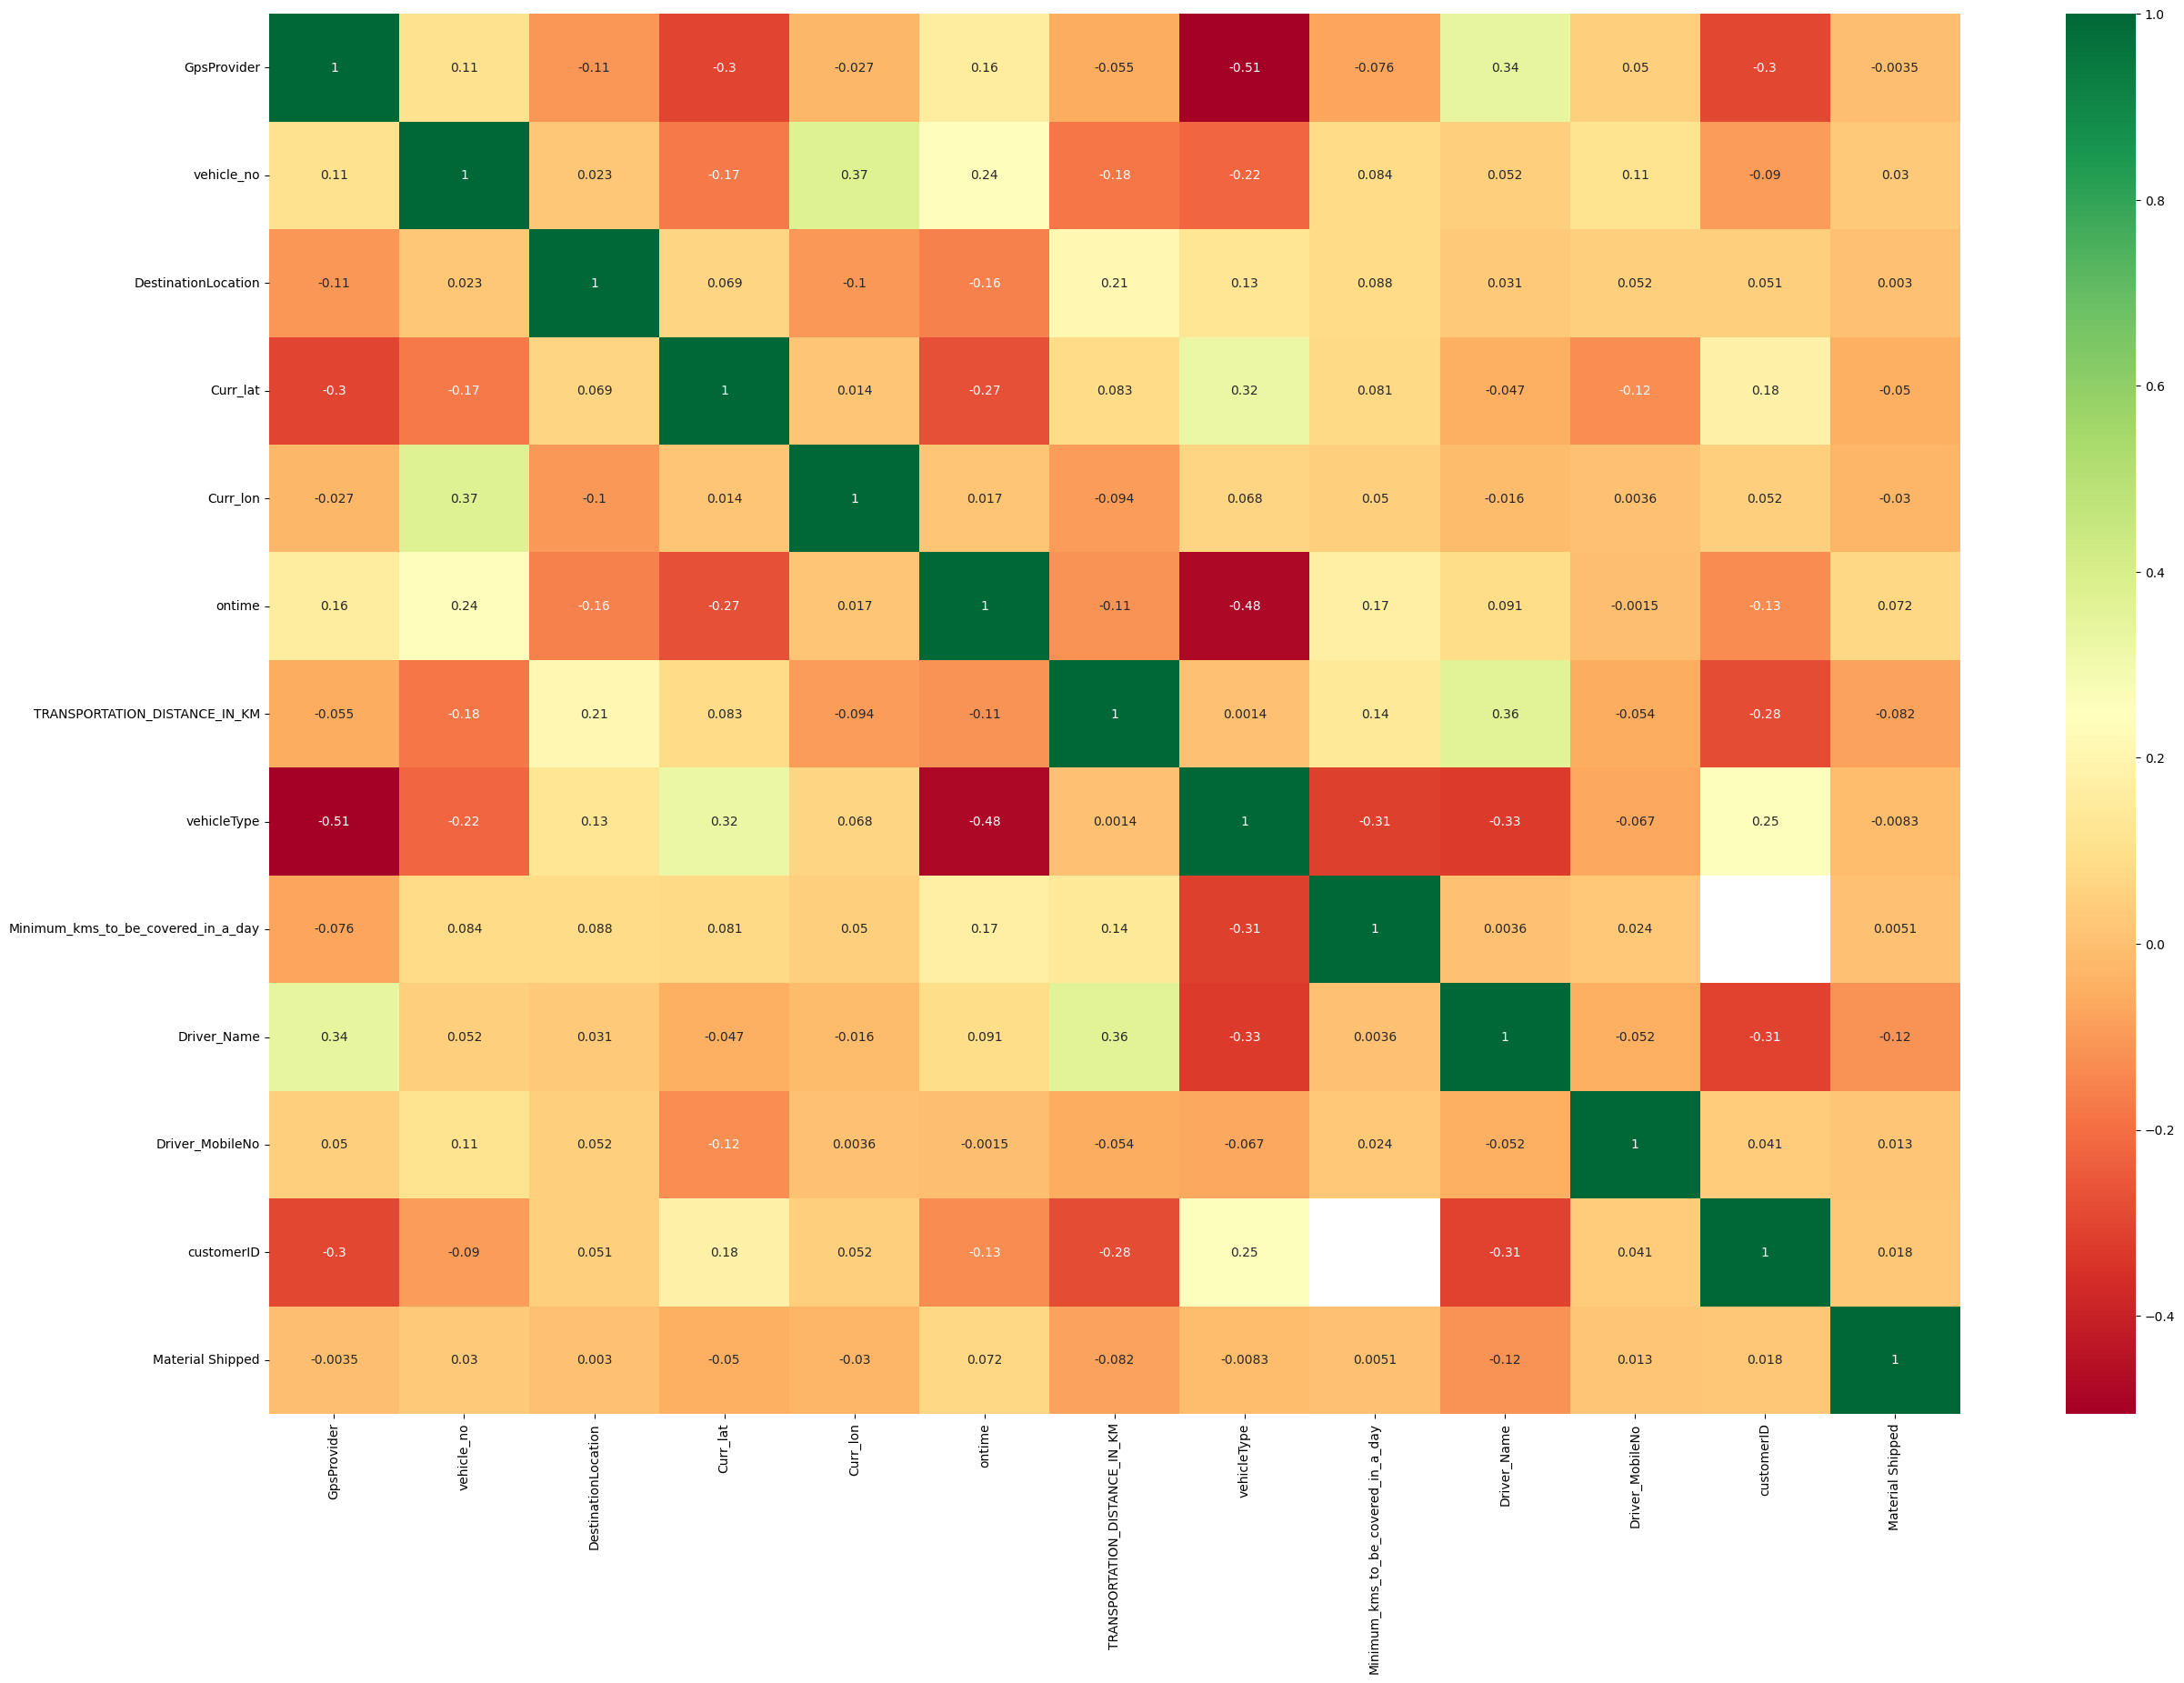

In [12]:
#Correlation matrix of uncleaned data
#non numerical data first has to be transformed to a category
# copy data to datacorr, otherwise problems occur when training model due to transformation to category
datacorr = data.copy()
datacorr['vehicleType']=datacorr['vehicleType'].astype('category').cat.codes
datacorr['ontime']=datacorr['ontime'].astype('category').cat.codes
datacorr['Driver_Name']=datacorr['Driver_Name'].astype('category').cat.codes
datacorr['Material Shipped']=datacorr['Material Shipped'].astype('category').cat.codes
datacorr['vehicle_no']=datacorr['vehicle_no'].astype('category').cat.codes
datacorr['customerID']=datacorr['customerID'].astype('category').cat.codes
datacorr['GpsProvider']=datacorr['GpsProvider'].astype('category').cat.codes
datacorr['DestinationLocation']=datacorr['DestinationLocation'].astype('category').cat.codes
corrmap = datacorr.corr()
top=corrmap.index
plt.figure(figsize=(30,20))
g=sns.heatmap(datacorr.corr(),annot=True,cmap="RdYlGn")

### Consideration after intial data exploration
1. Features related to current location and current lon and lat are difficult to understand but it seems they are inforamtion when the GPS ping is received. So there can be two alternative to build a model:
    a) one model is that when I input current time and location and other relevant input features, the model can predict ontime or not.
    b) another model is that it predict ontime or not before the trip. In this alternative, the "current" info is irrelevant.
    => Let's go for b)!
2. "Minimum_kms_to_be_covered_in_a_day", "Driver Mobil No", "Drive name" have more than 45% NaN -> Drop them.
3. "veichleType" is more informative than "vechile_no"(registration number?) which has high cardinality (2325 unique).But the former has high NaN(>800). Still I use the former feature and fill the NaNs with 'unknown'.
3. "BookingID" is an uniform distribution 6880 count vs 6875 unique. -> Drop this.
4. "BookingID_date" means little for the truck tranportation ontime question. -> Drop them.
5. "DestinationLocation" is duplication of "Destination_Location" -> Drop it.
6. I use code and ID instead of actual name. I use origincode, destinationcode, customerID, and supplierID
7. Ontime and delay columns are redundant. Change Onetime coloume to 1 or 0.
8. Since I go for b), 'trip_end_date' and 'atual_eta' cannot be input features. -> Drop them.
9. I wonder certain month and hours affect the target feature. One way is to separate them. -> I do not do this so far. 
10. 'Transpotation distance in km' can be an important featue but 712 NaN. For those, I can replace them with the direct distance between origin and destination lon/lat.
11. What can I do with two remaining columns of 'trip_start_date' and 'Planned_ETA'? Maybe I can create a new colum with expected travel time (hours) from these two.

Here is a screenshot when I explore the data with MITO.

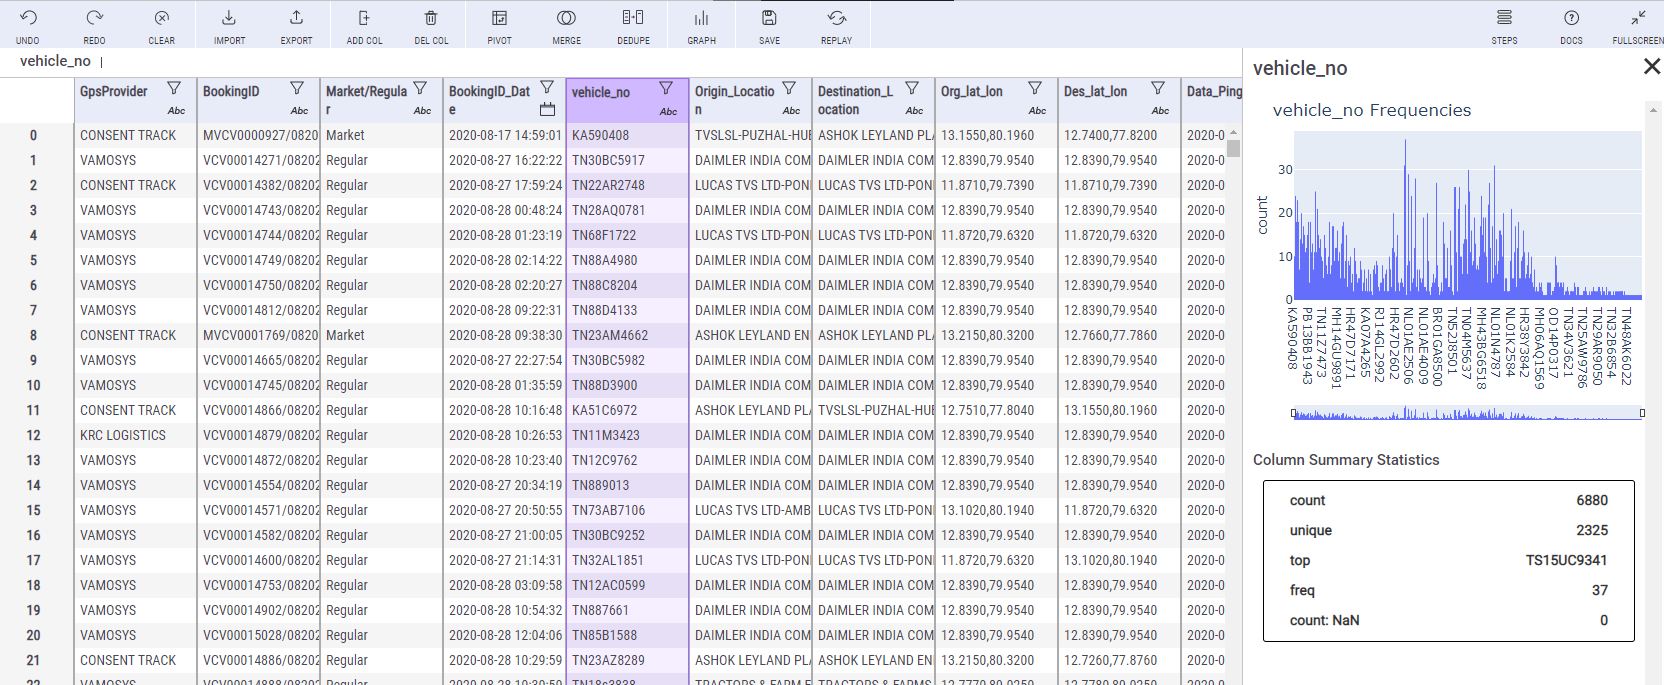

## 2. Data cleaning

### 2.1 First cleaned dataset (Original notebook)

In [13]:
data1 = data.copy()
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6880 entries, 0 to 6879
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   GpsProvider                         5927 non-null   object        
 1   BookingID                           6880 non-null   object        
 2   Market/Regular                      6880 non-null   object        
 3   BookingID_Date                      6880 non-null   datetime64[ns]
 4   vehicle_no                          6880 non-null   object        
 5   Origin_Location                     6880 non-null   object        
 6   Destination_Location                6880 non-null   object        
 7   Org_lat_lon                         6880 non-null   object        
 8   Des_lat_lon                         6880 non-null   object        
 9   Data_Ping_time                      5927 non-null   datetime64[ns]
 10  Planned_ETA             

In [14]:
# 8. Change ontime colunm to 1 for ontime and 0 for delay
print("data rows:", len(data1.index))
data1.ontime.replace({'G':1, np.NaN:0}, inplace=True)
# 3. Replace NaN with unknown for vechicle type
data1.vehicleType.replace(np.NaN, 'unknown', inplace=True)
# 11. Filling NaN in Transportation distance with difference in lon/lot of origin and destination
# Resulting in distance in bird's eye view, leading to small errors
geodistance_km = []
for row in data.itertuples(index=False):
   geodistance_km.append(distance.distance(row.Org_lat_lon, row.Des_lat_lon).km)

data1['geodistaince_km']=geodistance_km

# Replace NaN row in 'TRANSPORTATION_DISTANCE_IN_KM' with geodisatnce values
data1.TRANSPORTATION_DISTANCE_IN_KM.fillna(data1.geodistaince_km, inplace=True)
#12. Create the expected travel time in hours
data1['expected_travelhours']=(data1.Planned_ETA-data1.trip_start_date).astype('timedelta64[h]')

# There are negative travel hours. I replace them with 0 hour.
data1.expected_travelhours[data1.expected_travelhours<0]=0
data1.expected_travelhours.sort_values()

# 6784 row can be dropped, because it looks like an outlier.
data1.drop(index=6784,axis=0,inplace=True)
print("data rows:", len(data1.index))

data rows: 6880
data rows: 6879


In [15]:
# Based on the consideration above, I use the following the first 9 columes as input features. The last one is the target.
data_use1 = data1[['Market/Regular ','OriginLocation_Code','DestinationLocation_Code',
                 'TRANSPORTATION_DISTANCE_IN_KM','expected_travelhours','vehicleType',
                 'customerID','supplierID','Material Shipped','ontime']]

# There are still some NaNs. 
data_use1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6879 entries, 0 to 6879
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Market/Regular                 6879 non-null   object 
 1   OriginLocation_Code            6876 non-null   object 
 2   DestinationLocation_Code       6852 non-null   object 
 3   TRANSPORTATION_DISTANCE_IN_KM  6879 non-null   float64
 4   expected_travelhours           6879 non-null   float64
 5   vehicleType                    6879 non-null   object 
 6   customerID                     6879 non-null   object 
 7   supplierID                     6879 non-null   object 
 8   Material Shipped               6879 non-null   object 
 9   ontime                         6879 non-null   float64
dtypes: float64(3), object(7)
memory usage: 591.2+ KB


In [16]:
#Generate new excel after data cleaning and pre-processing
data_use1.to_excel("../input/delivery-truck-trips-data/cleanedData1.xlsx")  

In [17]:
# They are not many som just trop them.
print("data rows:", len(data_use1.index))
data_use1.dropna(axis=0,inplace=True)
print("data rows:", len(data_use1.index))

# I also found that three columes have mixed type. Integers blended into string columns. 
data_use1.applymap(type).nunique()
print("data rows:", len(data_use1.index))

data rows: 6879
data rows: 6849
data rows: 6849


In [18]:
# Fix these columns
data_use1['OriginLocation_Code'] = data_use1['OriginLocation_Code'].apply(str)
data_use1['DestinationLocation_Code'] = data_use1['DestinationLocation_Code'].apply(str)
data_use1['supplierID'] = data_use1['supplierID'].apply(str)
print("data rows:", len(data1.index))
# Now data is cleaned, and feature extraction is done!

data rows: 6879


### 2.2 Second cleaned dataset

In [521]:
print("data rows:", len(data2.index))
data2 = data.copy()
data2 = data2.drop('Minimum_kms_to_be_covered_in_a_day', axis=1)
data2 = data2.drop('Driver_MobileNo', axis=1)
data2 = data2.drop('GpsProvider', axis=1)
data2 = data2.drop('DestinationLocation', axis=1)
data2 = data2.drop('trip_end_date', axis=1) #manual inserted = not reliable

data rows: 6880


In [522]:
# 8. Change ontime colunm to 1 for ontime and 0 for delay
print('Size data 2:', data2.size)
data2.ontime.replace({'G':1, np.NaN:0}, inplace=True)
#Remove 49% of missing drivers
data2['Driver_Name'] = data2['Driver_Name'].replace(np.nan, 0)
data2 = data2.loc[data2["Driver_Name"] != 0]
print('Size data 2:', data2.size)
#Remove 12% of missing vehicle Types
data2['vehicleType'] = data2['vehicleType'].replace(np.nan, 0)
data2 = data2.loc[data2["vehicleType"] != 0]
print('Size data 2:', data2.size)
# 11. Filling NaN in Transportation distance with difference in lon/lot of origin and destination
# Resulting in distance in bird's eye view, leading to small errors
geodistance_km = []
for row in data2.itertuples(index=False):
   geodistance_km.append(distance.distance(row.Org_lat_lon, row.Des_lat_lon).km)
data2['geodistaince_km']=geodistance_km
# Replace NaN row in 'TRANSPORTATION_DISTANCE_IN_KM' with geodisatnce values
data2.TRANSPORTATION_DISTANCE_IN_KM.fillna(data2.geodistaince_km, inplace=True)

#12. Create the expected travel time in hours
data2['expected_travelhours']=(data2.Planned_ETA-data2.trip_start_date).astype('timedelta64[h]')

# There are negative travel hours. I replace them with 0 hour.
data2.expected_travelhours[data2.expected_travelhours<0]=0
data2.expected_travelhours.sort_values()

print("data rows:", len(data2.index))

Size data 2: 185760
Size data 2: 93177
Size data 2: 72684
data rows: 2692


In [524]:
print(data2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2692 entries, 59 to 4319
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   BookingID                      2692 non-null   object        
 1   Market/Regular                 2692 non-null   object        
 2   BookingID_Date                 2692 non-null   datetime64[ns]
 3   vehicle_no                     2692 non-null   int16         
 4   Origin_Location                2692 non-null   object        
 5   Destination_Location           2692 non-null   int16         
 6   Org_lat_lon                    2692 non-null   object        
 7   Des_lat_lon                    2692 non-null   object        
 8   Data_Ping_time                 2692 non-null   datetime64[ns]
 9   Planned_ETA                    2692 non-null   datetime64[ns]
 10  Current_Location               2681 non-null   object        
 11  actual_eta      

In [533]:
data_use2 = data2[['Market/Regular ','Origin_Location','Destination_Location',
                 'TRANSPORTATION_DISTANCE_IN_KM','Planned_ETA','trip_start_date','expected_travelhours','vehicleType',
                 'customerID','supplierID','Material Shipped','Driver_Name', 'ontime']]

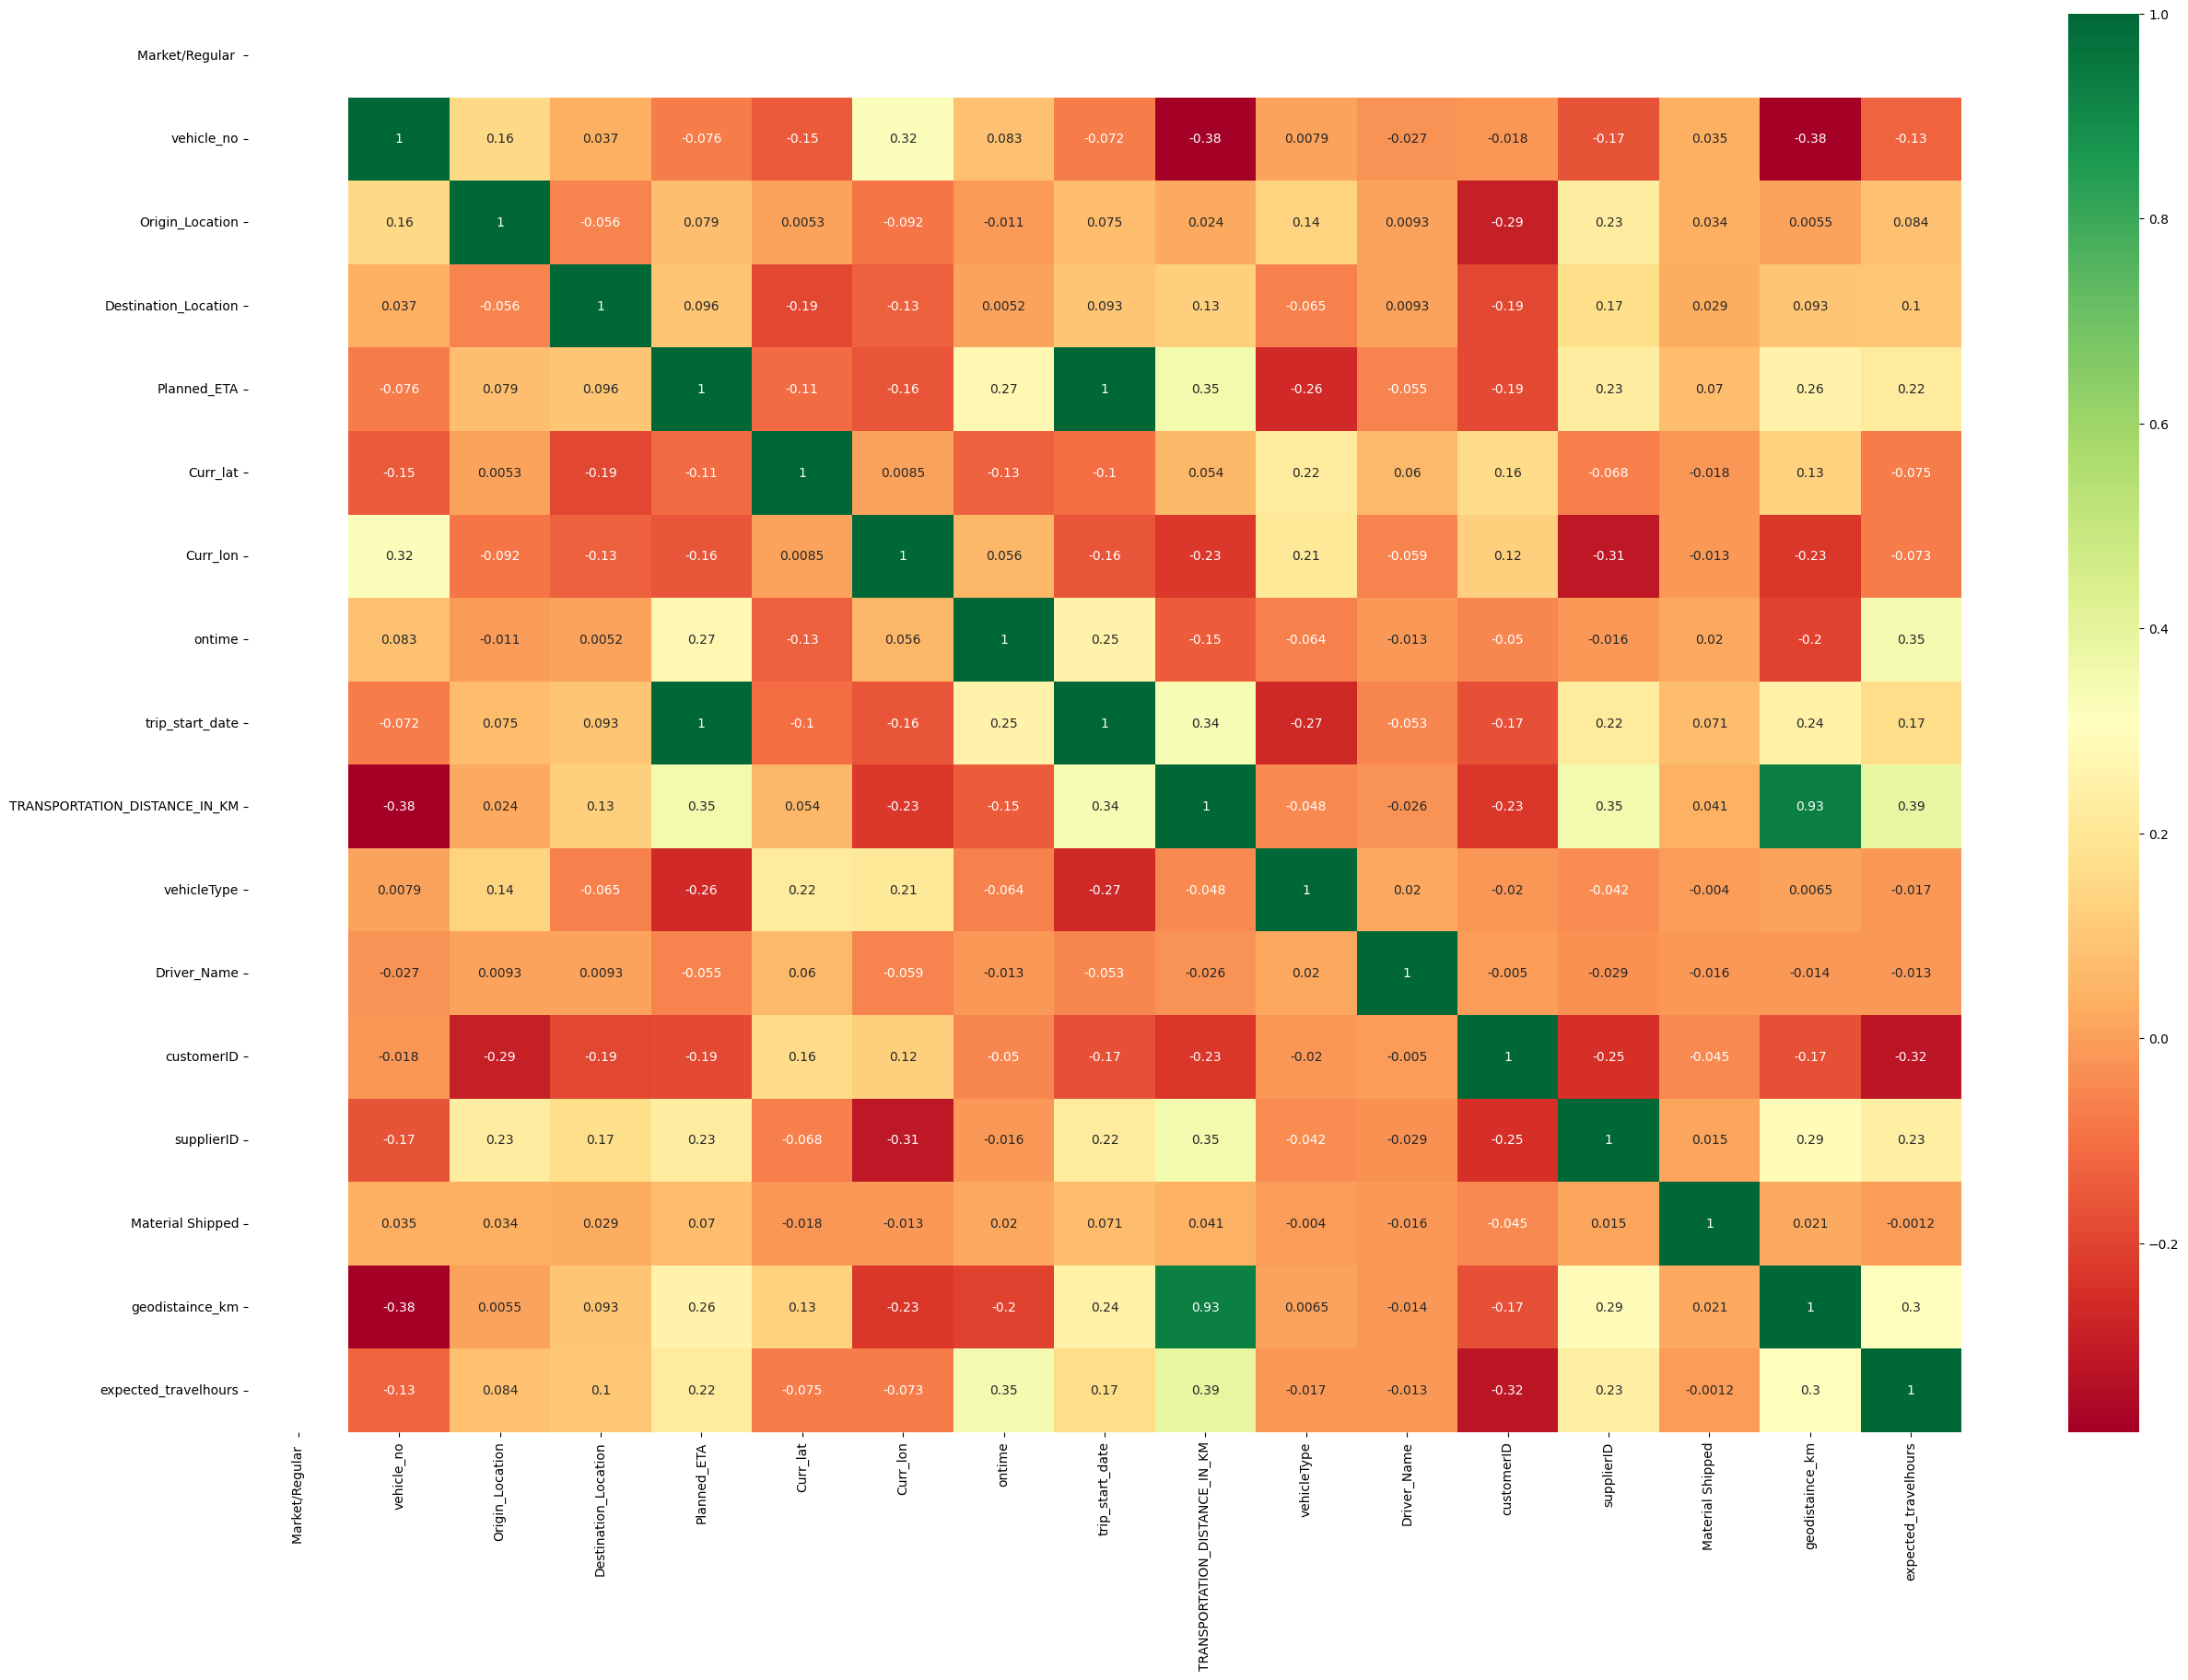

In [534]:
#correlation matrix on dataset2
datacorr2 = data2.copy()
datacorr2['Market/Regular ']=datacorr2['Market/Regular '].astype('category').cat.codes
datacorr2['Origin_Location']=datacorr2['Origin_Location'].astype('category').cat.codes
datacorr2['Destination_Location']=datacorr2['Destination_Location'].astype('category').cat.codes
datacorr2['Planned_ETA']=datacorr2['Planned_ETA'].astype('category').cat.codes
datacorr2['trip_start_date']=datacorr2['trip_start_date'].astype('category').cat.codes
datacorr2['vehicleType']=datacorr2['vehicleType'].astype('category').cat.codes
datacorr2['customerID']=datacorr2['customerID'].astype('category').cat.codes
datacorr2['supplierID']=datacorr2['supplierID'].astype('category').cat.codes
datacorr2['Material Shipped']=datacorr2['Material Shipped'].astype('category').cat.codes
datacorr2['Driver_Name']=datacorr2['Driver_Name'].astype('category').cat.codes
datacorr2['ontime']=datacorr2['ontime'].astype('category').cat.codes
corrmap = datacorr2.corr()
top=corrmap.index
plt.figure(figsize=(30,20))
g=sns.heatmap(datacorr2.corr(),annot=True,cmap="RdYlGn")

In [526]:
#Generate new excel after data cleaning and pre-processing
data_use2.to_excel("input/delivery-truck-trips-data/cleanedData2.xlsx")  

In [567]:
# They are not many so just trop them.
print("data rows:", len(data_use2.index))
data_use2.dropna(axis=0,inplace=True)
print("data rows:", len(data_use2.index))

# I also found that three columes have mixed type. Integers blended into string columns. 
data_use2.applymap(type).nunique()

data rows: 2692
data rows: 2692


Market/Regular                   1
Origin_Location                  1
Destination_Location             1
TRANSPORTATION_DISTANCE_IN_KM    1
Planned_ETA                      1
trip_start_date                  1
expected_travelhours             1
vehicleType                      1
customerID                       1
supplierID                       1
Material Shipped                 1
Driver_Name                      1
ontime                           1
dtype: int64

In [536]:
# Fix these columns
data_use2['Origin_Location'] = data_use2['Origin_Location'].apply(str)
data_use2['Destination_Location'] = data_use2['Destination_Location'].apply(str)
data_use2['supplierID'] = data_use2['supplierID'].apply(str)

# Now data is cleaned, and feature extraction is done!

### 2.3 Third cleaned data

In [19]:
data3 = data.copy()
data3 = data3.drop('Minimum_kms_to_be_covered_in_a_day', axis=1)
data3 = data3.drop('Driver_MobileNo', axis=1)
data3 = data3.drop('GpsProvider', axis=1)
data3 = data3.drop('DestinationLocation', axis=1)
data3 = data3.drop('trip_end_date', axis=1) #manual inserted = not reliable
print("data rows:", len(data3.index))

data rows: 6880


In [20]:
# 8. Change ontime colunm to 1 for ontime and 0 for delay
data3.ontime.replace({'G':1, np.NaN:0}, inplace=True)
# 11. Filling NaN in Transportation distance with difference in lon/lot of origin and destination
# Resulting in distance in bird's eye view, leading to small errors
geodistance_km = []
for row in data3.itertuples(index=False):
   geodistance_km.append(distance.distance(row.Org_lat_lon, row.Des_lat_lon).km)
data3['geodistaince_km']=geodistance_km
# Replace NaN row in 'TRANSPORTATION_DISTANCE_IN_KM' with geodisatnce values
data3.TRANSPORTATION_DISTANCE_IN_KM.fillna(data3.geodistaince_km, inplace=True)

#12. Create the expected travel time in hours
data3['expected_travelhours']=(data3.Planned_ETA-data3.trip_start_date).astype('timedelta64[h]')

# There are negative travel hours. I replace them with 0 hour.
data3.expected_travelhours[data3.expected_travelhours<0]=0
data3.expected_travelhours.sort_values()
print("data rows:", len(data3.index))

data rows: 6880


In [21]:
print(data3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6880 entries, 0 to 6879
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   BookingID                      6880 non-null   object        
 1   Market/Regular                 6880 non-null   object        
 2   BookingID_Date                 6880 non-null   datetime64[ns]
 3   vehicle_no                     6880 non-null   object        
 4   Origin_Location                6880 non-null   object        
 5   Destination_Location           6880 non-null   object        
 6   Org_lat_lon                    6880 non-null   object        
 7   Des_lat_lon                    6880 non-null   object        
 8   Data_Ping_time                 5927 non-null   datetime64[ns]
 9   Planned_ETA                    6880 non-null   datetime64[ns]
 10  Current_Location               5916 non-null   object        
 11  actual_eta       

In [22]:
print("data rows:", len(data3.index))
data_use3 = data3[['Market/Regular ','Origin_Location','Destination_Location',
                 'TRANSPORTATION_DISTANCE_IN_KM','Planned_ETA','trip_start_date','expected_travelhours','vehicleType',
                 'customerID','supplierID','Material Shipped','Driver_Name', 'ontime']]
print("data rows:", len(data_use3.index))

data rows: 6880
data rows: 6880


In [23]:
#Generate new excel after data cleaning and pre-processing
data_use3.to_excel("../input/delivery-truck-trips-data/cleanedData3.xlsx")  

In [24]:
# They are not many so just trop them.
print("data rows:", len(data_use3.index))
# I also found that three columes have mixed type. Integers blended into string columns. 
data_use3.applymap(type).nunique()
print("data rows:", len(data_use3.index))

data rows: 6880
data rows: 6880


In [25]:
# Fix these columns
data_use3['Origin_Location'] = data_use3['Origin_Location'].apply(str)
data_use3['Destination_Location'] = data_use3['Destination_Location'].apply(str)
data_use3['supplierID'] = data_use3['supplierID'].apply(str)
print("data rows:", len(data_use3.index))
# Now data is cleaned, and feature extraction is done!

data rows: 6880


## 3. Preprocessing and training the model

### 3.1 Decision Tree first cleaned dataset

In [26]:
# Take a copy for preprocessing
df = data_use1.copy()
#print("data rows:", len(data_use2.index))
#df = data_use2.copy()
#df = data_use3.copy()
print("data rows:", len(df.index))

# Make X and y
X = df.drop(columns='ontime', axis=1)
y = df['ontime']

# Since applying OrdinalEncoder after split cause unknown-category error in testset. The version of sklearn in Kaggle (0.23) cannot handle this. 
# There are two options. 1) Not optimal but I apply encoder now, or 2) Apply OneHotEncoder after the split. I go for 1).   
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
#columns for dataset 1
cat_columns = ['Market/Regular ','OriginLocation_Code','DestinationLocation_Code','vehicleType','customerID','supplierID','Material Shipped']
#for dataset 2 and 3
#cat_columns = ['Market/Regular ','Origin_Location','Destination_Location','Planned_ETA','trip_start_date','vehicleType','customerID','supplierID','Material Shipped','Driver_Name']

X[cat_columns] = encoder.fit_transform(X[cat_columns])

# split X y to train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

data rows: 6849


In [27]:
#Generata synthetic data to enlarger dataset with the same distribution
#!pip install tonic_api
#from tonic_api.api import TonicApi

#tonic = TonicApi("https://djinn.tonic.ai", "5CD7zaFZjvdrxt5k2HrcLfdLzvKzNAdrbpumh3t6roE27wausIFIJUcWGjLS2PaT")

# Hackathon determined
#workspace = tonic.get_workspace("e0315dde-2016-ba0b-f938-bc88e0b54add")

#model = workspace.get_trained_model_by_training_job_id("795d9dac-70d3-e60c-4b52-579561cf990d")
#sample = model.sample(5)
#print(sample)
#sample.to_excel("input/delivery-truck-trips-data/samples.xlsx")  

In [29]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
print(y_proba)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
cm =confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

[[0.03721863 0.96278137]
 [0.01330787 0.98669213]
 [0.8512464  0.1487536 ]
 ...
 [0.64943373 0.35056627]
 [0.00512749 0.9948725 ]
 [0.11158425 0.88841575]]
[[1234   72]
 [ 104  645]]
accuracy: 0.9143552311435523
precision: 0.899581589958159
recall: 0.8611481975967957


<AxesSubplot: title={'center': 'Confusion Matrix with labels\n\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

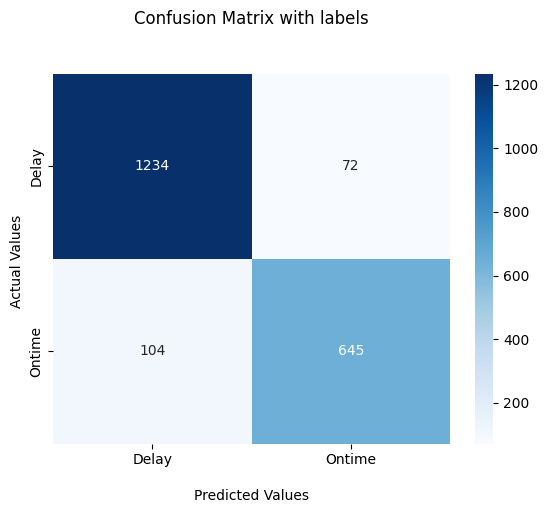

In [24]:
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels 
ax.xaxis.set_ticklabels(['Delay','Ontime'])
ax.yaxis.set_ticklabels(['Delay','Ontime'])

## Display the visualization of the Confusion Matrix.
ax

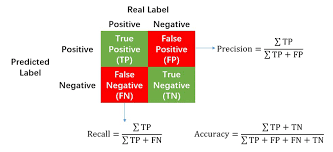

In [25]:
# Let's try with some other parameters than default parameters if the result becomes better.

model_2 = XGBClassifier(n_estimators=1500, learning_rate=0.05, n_jobs=4)
model_2.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], 
             verbose=False)
#NEW: Noticed an error: use of model and not model_2
y_pred_2 = model_2.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_2= confusion_matrix(y_test, y_pred_2)
print(cm_2)
print('accuracy:', accuracy_score(y_test, y_pred_2))
print('precision:', precision_score(y_test, y_pred_2))
print('recall:', recall_score(y_test, y_pred_2))

# Ok the same result. Maybe parameter tuning does not go further.

[[1242   64]
 [ 118  631]]
accuracy: 0.9114355231143553
precision: 0.9079136690647482
recall: 0.842456608811749


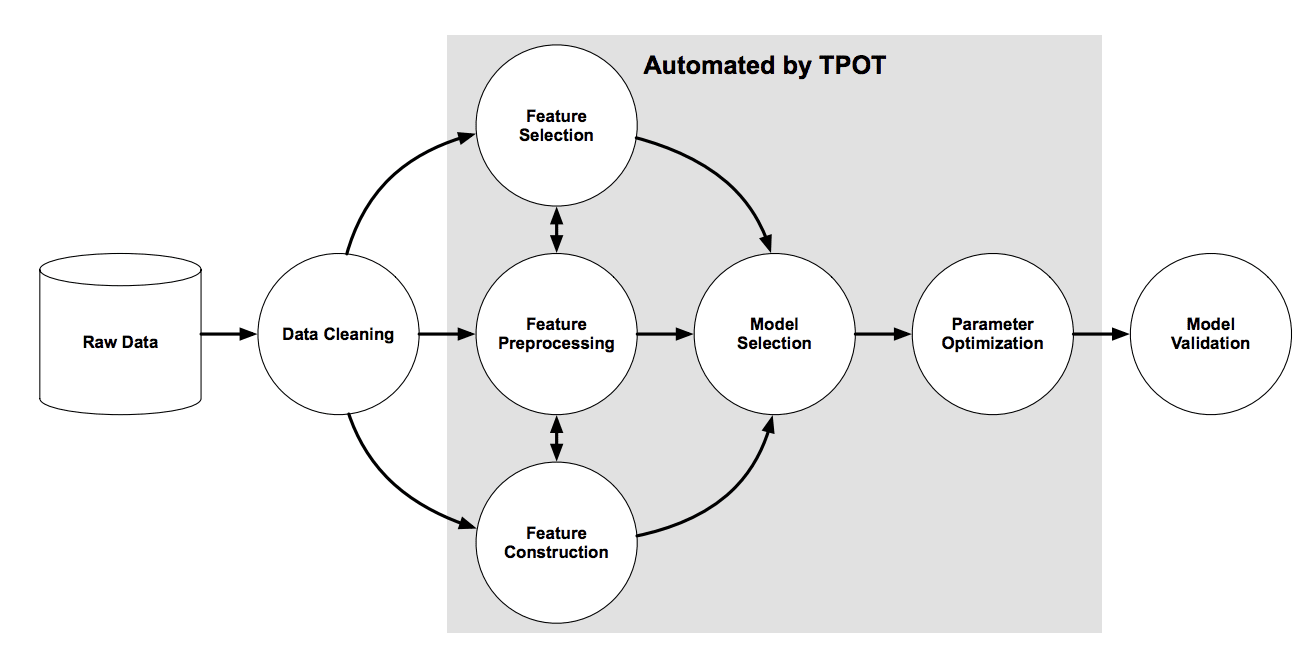

In [28]:
#Let's try and see if we get any different/optimal results when using TPOT. 
#TPOT is an autoML that optimizes machine learning pipelines using genetic programming.

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42, n_jobs=1)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

now = datetime.datetime.now()
timestamp = str(now.strftime("%Y%m%d_%H:%M:%S"))
tpot.export('tpot_pipeline_data1'+ timestamp +'.py')

                                                                              
Generation 1 - Current best internal CV score: 0.8957014200160657
                                                                                
Generation 2 - Current best internal CV score: 0.8957014200160657
                                                                                
Generation 3 - Current best internal CV score: 0.9040454022000126
                                                                                
Generation 4 - Current best internal CV score: 0.9046706185331364
                                                                              
Generation 5 - Current best internal CV score: 0.9046706185331364
                                                           
Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.9000000000000001, min_samples_leaf=1, min_samples_split=13, n_estimators=100)
0.9114355231143553


In [29]:
tpot_pred = tpot.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_3 = confusion_matrix(y_test, tpot_pred)
print(cm_3)
print('accuracy:', accuracy_score(y_test, tpot_pred))
print('precision:', precision_score(y_test, tpot_pred))
print('recall:', recall_score(y_test, tpot_pred))

[[1228   78]
 [ 104  645]]
accuracy: 0.9114355231143553
precision: 0.8921161825726142
recall: 0.8611481975967957


### 3.2 Decision Tree third cleaned dataset

In [26]:
# Take a copy for preprocessing
df = data_use3.copy()
print("data rows:", len(df.index))

# Make X and y
X = df.drop(columns='ontime', axis=1)
y = df['ontime']

# Since applying OrdinalEncoder after split cause unknown-category error in testset. The version of sklearn in Kaggle (0.23) cannot handle this. 
# There are two options. 1) Not optimal but I apply encoder now, or 2) Apply OneHotEncoder after the split. I go for 1).   
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
cat_columns = ['Market/Regular ','Origin_Location','Destination_Location','Planned_ETA','trip_start_date','vehicleType','customerID','supplierID','Material Shipped','Driver_Name']

X[cat_columns] = encoder.fit_transform(X[cat_columns])

# split X y to train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

data rows: 6880


In [30]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

print(y_proba)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
cm =confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

[[0.03721863 0.96278137]
 [0.01330787 0.98669213]
 [0.8512464  0.1487536 ]
 ...
 [0.64943373 0.35056627]
 [0.00512749 0.9948725 ]
 [0.11158425 0.88841575]]
[[1234   72]
 [ 104  645]]
accuracy: 0.9143552311435523
precision: 0.899581589958159
recall: 0.8611481975967957


In [ ]:
#Let's try and see if we get any different/optimal results when using TPOT. 
#TPOT is an autoML that optimizes machine learning pipelines using genetic programming.

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42, n_jobs=1)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

now = datetime.datetime.now()
timestamp = str(now.strftime("%Y%m%d_%H:%M:%S"))
tpot.export('tpot_pipeline_data3'+ timestamp +'.py')

Imputing missing values in feature set
                                                                              
Generation 1 - Current best internal CV score: 0.9404049413356429
                                                                                
Generation 2 - Current best internal CV score: 0.9404049413356429
Optimization Progress:  60%|██████    | 180/300 [09:12<05:15,  2.63s/pipeline]

In [ ]:
tpot_pred = tpot.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_3 = confusion_matrix(y_test, tpot_pred)
print(cm_3)
print('accuracy:', accuracy_score(y_test, tpot_pred))
print('precision:', precision_score(y_test, tpot_pred))
print('recall:', recall_score(y_test, tpot_pred))

## 4. Model evaluation and explanation

### Analysis with SHAP 
I also used ExplianerDash. This is also very helping to getting insights about the mode quckly without much coding.

In [ ]:
explainer = shap.explainers.Tree(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, show=False)

fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(10)
plt.show()

I attach some of the further analysis with dependancy plots, using ExplainerDash.

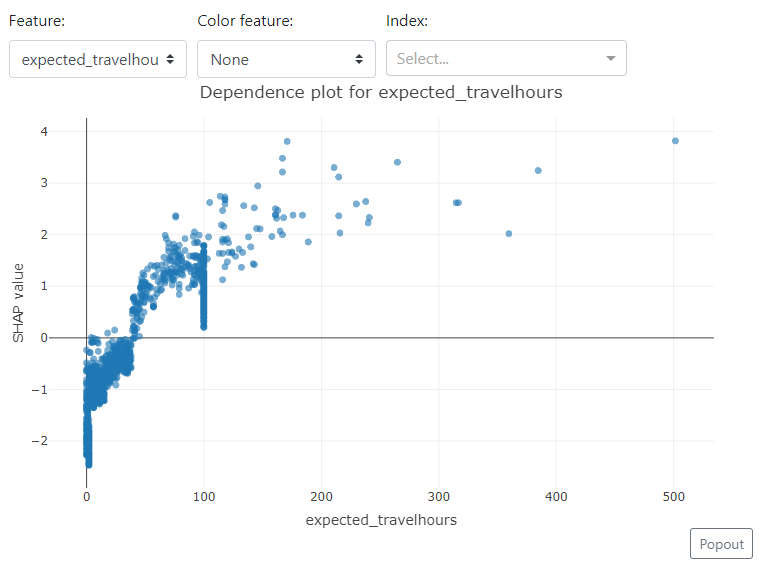


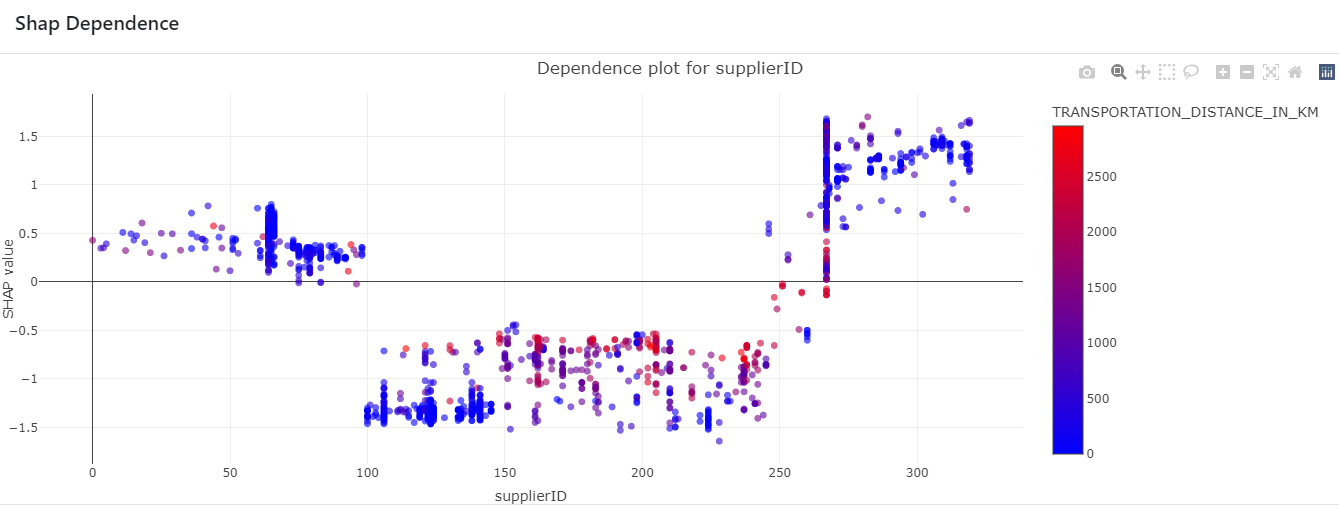


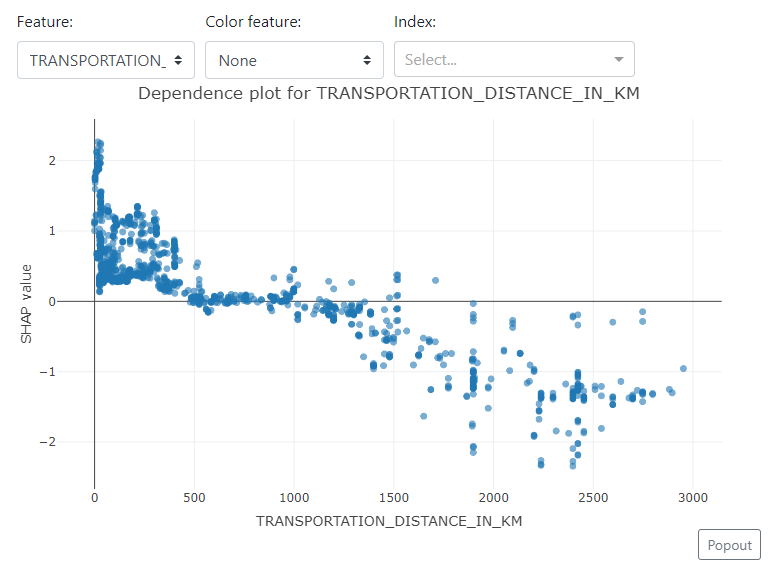


### Anslysis and insights
* expected_travelhours: Generally longer expected travel hours positively affect the ontime prediction. Shoter time is the opposite.
* supplier: Not exactly why it has a high influence to the prediction. OrdinalEncoder econdes in an alphabetical order (acc. to the doc), thus the distriubtion in x does not mean anything. From the dependancy plot, I can see that supplies with longer travel distace generally negatively affect the ontime prediction.
* transportation distace: Shorter distance positively affect on the ontime prediction. The opposite goes for the longer distance.
* Origin and destination: Difficult to interpret this categirical features.
* Other features only limitedly influence on the prediction.

### Can this model be applied in a real life?
* The metrics of the model may be improved with some extra effort but I do not do this now. 
* Accuracy and precision are rather ok (around 90%). Recall is a bit lower. The model may be used for a non-critical application, for instance, a model integrated app informs logistic planners to ontime/delpay prediction with probablity. With ontime prediction with higher probablity, the planner does not need to do any specific. When the prediction is delay or low probability, the planner can ask or change the planning system so that truck companies/drives can depart some time earlier (how early depends on the traveling distance). 
